## Purpose
Example showing the `UseLowestEnergy` feature of the Hybrid engine and the `OptimizeSpinRound` feature of the ADF engine.

A bond scan is performed on hydrogen peroxide with UFF. The resulting
structures are then recalculated with DFT using four different setups. In
particular, one setup uses the Hybrid engine with DynamicFactors=UseLowestEnergy.
Another uses the ADF engine with `OptimizeSpinRound` in combination with an `ElectronicTemperature`.

In the end, the results of energy vs. bond length are plotted.

## Initial imports

In [1]:
import matplotlib.pyplot as plt
from scm.plams import from_smiles, Settings, AMSJob, Units, init

# this line is not required in AMS2025+
init()

PLAMS working folder: /path/plams/plams_workdir


## Helper functions

In [2]:
def initial_pesscan():
    """Run a bond scan for hydrogen peroxide with UFF. Returns the finished job"""
    mol = from_smiles("OO")  # hydrogen peroxide
    s = Settings()
    s.input.ams.Task = "PESScan"
    s.input.ams.PESScan.ScanCoordinate.nPoints = 7
    # Scan O-O bond length (atoms 1 and 2) between 1.2 and 2.5 Å
    s.input.ams.PESScan.ScanCoordinate.Distance = "2 1 1.2 2.5"
    s.input.ForceField.Type = "UFF"
    job = AMSJob(settings=s, molecule=mol, name="initial_pesscan")
    job.run()
    return job


def singlet_settings(header=""):
    s = Settings()
    s.Unrestricted = "No"
    s.XC.GGA = "PBE"
    s.Basis.Type = "DZP"
    s.SCF.Iterations = 100
    s._h = header
    return s


def triplet_settings(header=""):
    s = Settings()
    s.Unrestricted = "Yes"
    s.SpinPolarization = 2
    s.XC.GGA = "PBE"
    s.Basis.Type = "DZP"
    s.SCF.Iterations = 100
    s._h = header
    return s


def hybrid_settings():
    """Look at the file plams_workdir/hybrid/hybrid.in to see how the below is translated into text input for the hybrid engine"""
    s = Settings()
    s.input.Hybrid.Energy.DynamicFactors = "UseLowestEnergy"

    s.input.Hybrid.Energy.Term = ["Region=* EngineID=Singlet", "Region=* EngineID=Triplet"]

    s.input.Hybrid.Engine = [singlet_settings("ADF Singlet"), triplet_settings("ADF Triplet")]
    return s


def replay_job(rkf, engine="hybrid"):
    """Replay the structures from the UFF pesscan with ADF. Use three different engines:
    Hybrid: This will run all structures with both Singlet and Triplet and pick the lowest energy
    Singlet: This runs all structures using the Singlet settings
    Triplet: This runs all structures using the Triplet settings

    Returns the finished job
    """
    s = Settings()
    if engine == "hybrid":
        s = hybrid_settings()
    elif engine == "singlet":
        s.input.adf = singlet_settings()
    elif engine == "triplet":
        s.input.adf = triplet_settings()
    elif engine == "optimizespin":
        s.input.adf = triplet_settings()
        s.input.adf.Occupations = "ElectronicTemperature=300 OptimizeSpinRound=0.05"

    s.input.ams.Task = "Replay"
    s.input.ams.Replay.File = rkf

    job = AMSJob(settings=s, name=engine)
    job.run()
    return job


def plot_results(singlet_job, triplet_job, hybrid_job, optimizespin_job):
    """
    Generate a plot of the energy vs. bond length for the three different jobs.  Saves a plot to pesplot.png.
    """
    bondlengths = singlet_job.results.get_pesscan_results()["RaveledPESCoords"][0]
    bondlengths = Units.convert(bondlengths, "bohr", "angstrom")

    singlet_pes = singlet_job.results.get_pesscan_results()["PES"]
    triplet_pes = triplet_job.results.get_pesscan_results()["PES"]
    hybrid_pes = hybrid_job.results.get_pesscan_results()["PES"]
    hybrid_pes = [x - 0.005 for x in hybrid_pes]  # slightly downshift for visual clarity when plotting
    optimizespin_pes = optimizespin_job.results.get_pesscan_results()["PES"]
    optimizespin_pes = [x - 0.010 for x in optimizespin_pes]  # slightly downshift for visual clarity when plotting

    plt.plot(bondlengths, singlet_pes)
    plt.plot(bondlengths, triplet_pes)
    plt.plot(bondlengths, hybrid_pes)
    plt.plot(bondlengths, optimizespin_pes)
    plt.title("PES Scan for hydrogen peroxide")
    plt.xlabel("O-O bond length (Å)")
    plt.ylabel("Energy (hartree)")
    plt.legend(
        ["Singlet", "Triplet", "Hybrid: Lowest energy (slightly shifted)", "ADF: optimized spin (slightly shifted)"]
    )
    plt.savefig("pesplot.png")
    plt.show()

## Run the job

In [3]:
pesscan_job = initial_pesscan()
rkf = pesscan_job.results.rkfpath()
singlet_job = replay_job(rkf, "singlet")
triplet_job = replay_job(rkf, "triplet")
hybrid_job = replay_job(rkf, "hybrid")
optimizespin_job = replay_job(rkf, "optimizespin")
# or load the finished jobs from disk:
# pesscan_job = AMSJob.load_external('plams_workdir.002/initial_pesscan/ams.rkf')
# rkf = pesscan_job.results.rkfpath()
# singlet_job = AMSJob.load_external('plams_workdir.002/singlet/ams.rkf')
# triplet_job = AMSJob.load_external('plams_workdir.002/triplet/ams.rkf')
# hybrid_job = AMSJob.load_external('plams_workdir.002/hybrid/ams.rkf')
# optimizespin_job = AMSJob.load_external('plams_workdir.002/optimizespin/ams.rkf')

[04.03|14:01:29] JOB initial_pesscan STARTED
[04.03|14:01:29] JOB initial_pesscan RUNNING
[04.03|14:01:31] JOB initial_pesscan FINISHED
[04.03|14:01:31] Job initial_pesscan reported warnings. Please check the output
[04.03|14:01:31] JOB initial_pesscan SUCCESSFUL
[04.03|14:01:31] Job initial_pesscan reported warnings. Please check the output
[04.03|14:01:31] Job initial_pesscan reported warnings. Please check the output
[04.03|14:01:31] Job initial_pesscan reported warnings. Please check the output
[04.03|14:01:31] JOB singlet STARTED
[04.03|14:01:31] JOB singlet RUNNING
[04.03|14:01:42] JOB singlet FINISHED
[04.03|14:01:42] Job singlet reported warnings. Please check the output
[04.03|14:01:42] JOB singlet SUCCESSFUL
[04.03|14:01:42] Job singlet reported warnings. Please check the output
[04.03|14:01:42] Job singlet reported warnings. Please check the output
[04.03|14:01:42] Job singlet reported warnings. Please check the output
[04.03|14:01:42] JOB triplet STARTED
[04.03|14:01:42] JO

## Plot the result

Two equivalent to follow the lowest energy of the singlet and the triplet state, with either the Hybrid engine (green) or the optimize spin option (red) from ADF.

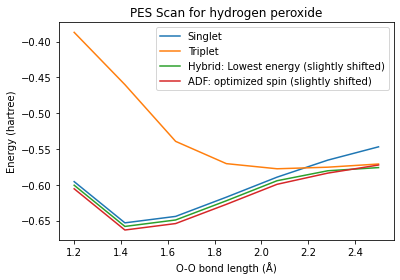

In [4]:
plot_results(singlet_job, triplet_job, hybrid_job, optimizespin_job)